In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import sympy 
from sympy import banded, ones, Matrix, symbols, sqrt, print_latex, oo
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import wofz 
import scipy
import pickle

In [3]:
%matplotlib inline
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## Asymmetrically Weighted Hermite w/ Hammett-Perkins (like) Linear Closures

In [10]:
# number of Hermite moments
Nv = 4

In [11]:
# define symbolic variables
xi= symbols('xi') 
k = symbols('k', integer = True)
c = symbols('c', complex = True)
b = symbols('b', complex = True)
a = symbols('a', complex = True)

In [12]:
# setup advection matrix off-diagonals
vec = sympy.zeros(Nv)
for jj in range(1, Nv+1):
    vec[jj-1] = sympy.sqrt(jj)/ (sympy.sqrt(2))

In [13]:
# setup A matrix
A = banded({1: tuple(vec[0, :-1]), -1: tuple(vec[0, :-1])})

In [14]:
# add linear closure assumption
A[-1, Nv-3] += sympy.I * a * sympy.sqrt(Nv)/ sympy.sqrt(2)  * k / np.abs(k)
A[-1, Nv-2] += sympy.I * b * sympy.sqrt(Nv)/ sympy.sqrt(2)  * k / np.abs(k)
A[-1, Nv-1] += sympy.I * c * sympy.sqrt(Nv)/ sympy.sqrt(2)  * k / np.abs(k)

In [15]:
A

Matrix([
[        0,            sqrt(2)/2,                                0,                    0],
[sqrt(2)/2,                    0,                                1,                    0],
[        0,                    1,                                0,            sqrt(6)/2],
[        0, sqrt(2)*I*a*k/Abs(k), sqrt(2)*I*b*k/Abs(k) + sqrt(6)/2, sqrt(2)*I*c*k/Abs(k)]])

In [18]:
# identity matrix
I = np.eye(Nv, dtype=int)

In [19]:
# eigenvalue matrix
M = sympy.Matrix(I*xi - k/np.abs(k)*A)

In [20]:
# inversion
R_approx = sympy.simplify(sympy.simplify(M.inv()[0, 1]/sympy.sqrt(2) * k/np.abs(k)))

In [21]:
R_approx

(2*sqrt(3)*b*Abs(k) + 2*sqrt(2)*c*k*xi + 2*I*k*xi**2 - 3*I*k)/(4*sqrt(3)*a*k*xi + 4*sqrt(3)*b*xi**2*Abs(k) - 2*sqrt(3)*b*Abs(k) + 4*sqrt(2)*c*k*xi**3 - 6*sqrt(2)*c*k*xi + 4*I*k*xi**4 - 12*I*k*xi**2 + 3*I*k)

In [22]:
print_latex(R_approx)

\frac{2 \sqrt{3} b \left|{k}\right| + 2 \sqrt{2} c k \xi + 2 i k \xi^{2} - 3 i k}{4 \sqrt{3} a k \xi + 4 \sqrt{3} b \xi^{2} \left|{k}\right| - 2 \sqrt{3} b \left|{k}\right| + 4 \sqrt{2} c k \xi^{3} - 6 \sqrt{2} c k \xi + 4 i k \xi^{4} - 12 i k \xi^{2} + 3 i k}


## Asymptotic Expansion

### Adiabatic limit $\xi \to 0$

In [ ]:
asymptotics_0 = R_approx.series(xi, 0, 4)

In [ ]:
asymptotics_0

In [ ]:
sol_coeff = sympy.solve([asymptotics_0.coeff(xi, 0) + 1,
                         asymptotics_0.coeff(xi, 1) + sympy.I*sympy.sqrt(sympy.pi), 
                         asymptotics_0.coeff(xi, 2) -2], [a, b, c])

In [ ]:
sol_coeff

In [ ]:
# save optimal 
with open("optimal_c_HP/coeff_" + str(Nv) + ".txt", "wb") as outf:
    pickle.dump(sol_coeff[0], outf)

In [ ]:
# save optimal R(nu*) (for k=1)
with open("optimal_R_HP/R_" + str(Nv) + ".txt", "wb") as outf:
    pickle.dump(sympy.simplify(R_approx.subs([(a, sol_coeff[0][0]), (b, sol_coeff[0][1]), (c, sol_coeff[0][2])])), outf)

### Fluid (cold plasma) limit $\xi \to \infty$

In [ ]:
asymptotics_inf = R_approx.series(xi, oo, 6)

In [ ]:
asymptotics_inf

In [ ]:
print_latex(asymptotics_inf)

## Comparison with Hammett-Perkins 1990's approximation

In [ ]:
def Z_fun(z):
    return 1j*np.sqrt(np.pi)*wofz(z)

def R(zeta):
    return -(1 + zeta*Z_fun(zeta))

def R_Hermite(zeta, Nv):
    with open('optimal_R_HP/R_' + str(Nv) + '.txt','rb') as f:
        return sympy.lambdify(xi, pickle.load(f))(zeta)

def RHP3(xi):
    return -(-1j*xi + (2/np.sqrt(np.pi)))/((2/(np.sqrt(np.pi))) - 3j*xi - 4/(np.sqrt(np.pi)) * (xi**2) + 2j*(xi**3))

def RHP4(xi):
    return (-4 + 2j*np.sqrt(np.pi)*xi + (3*np.pi -8)*(xi**2))/(4 - 6j*np.sqrt(np.pi)*xi - (9*np.pi - 16)*(xi**2) + 4j*np.sqrt(np.pi)*(xi**3) + 2*(3*np.pi - 8)*(xi**4))

In [ ]:
zeta = 10**np.linspace(-3, 3, int(1e3))

In [ ]:
R_HP3_like = R_Hermite(zeta, 3)
R_HP4_like = R_Hermite(zeta, 4)
R_true = R(zeta)

In [ ]:
R_HP3 = RHP3(zeta)
R_HP4 = RHP4(zeta)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(11, 5))

ax[0].plot(zeta, np.real(R_true), label=r"kinetic response $R(\xi)$", c="blue", linewidth=3)

ax[0].plot(zeta, np.real(R_HP3), "--", label=r"HP$_{3}$ (fluid)", c="red", linewidth=3, alpha=0.7)
ax[0].plot(zeta, np.real(R_HP4), "-", label=r"HP$_{4}$ (fluid)", c="orange", linewidth=3, alpha=0.7)
ax[0].plot(zeta, np.real(R_HP3_like), label=r"HP$_{3}$ (Hermite)", c="purple", ls="-.", linewidth=3, alpha=0.7)
ax[0].plot(zeta, np.real(R_HP4_like), label=r"HP$_{4}$ (Hermite)", c="green", ls=":", linewidth=3, alpha=0.7)

ax[1].plot(zeta, np.imag(R_true), c="blue", linewidth=3)
ax[1].plot(zeta, np.imag(R_HP3), "--", c="red", linewidth=3, alpha=0.7)
ax[1].plot(zeta, np.imag(R_HP4), "-",  c="orange", linewidth=3, alpha=0.7)
ax[1].plot(zeta, np.imag(R_HP3_like), ls="-.", c="purple", linewidth=3, alpha=0.7)
ax[1].plot(zeta, np.imag(R_HP4_like), ls="-.", c="green", linewidth=3, alpha=0.7)

ax[0].set_ylim(-1.5, 0.8)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_ylabel(r"$Re(R(\xi))$")
ax[1].set_ylabel(r"$Im(R(\xi))$")
ax[0].set_xlabel(r"$\xi = \omega/(|k|v_{t} \sqrt{2})$")
ax[1].set_xlabel(r"$\xi = \omega/(|k|v_{t} \sqrt{2})$")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_xlim(1e-2, 1e3)
ax[1].set_xlim(1e-2, 1e3)
legend = ax[0].legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
#plt.savefig("../figs/symbolic_response_function_SPS_HPlike.png", dpi=600)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))

for nn in range(4, 15, 2):
    ax.plot(zeta, np.abs(R_true - R_Hermite(zeta, Nv=nn)), label=r"$N_{v} = " + str(nn) + "$", linewidth=3)

ax.set_ylim(0, 0.25)
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|R(\xi) - R^{aw}(\xi, \nu^{*})|$")
ax.set_xlabel(r"$\xi = \omega/(|k|v_{t} \sqrt{2})$")
ax.set_xscale("log")
ax.set_xlim(1e-3, 1e3)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("figs/symbolic_response_function_AW_HP_Q3.png", dpi=200)

# Landau Damping Dispersion Relation

In [103]:
def disp_k(omega, k=1):
    return k**2 - R(zeta=omega/(np.sqrt(2)*k))

def disp_hp3(omega, k=1, nu=1):
    return k**2 - RHP3(xi=omega/(k*np.sqrt(2)))

def disp_hp4(omega, k=1, nu=1):
    return k**2 - RHP4(xi=omega/(k*np.sqrt(2)))

def disp_R6(omega, k=1, nu=1):
    return k**2 -  R6(zeta=omega/(k*np.sqrt(2)), col=nu)

In [104]:
res_true = scipy.optimize.newton(disp_k, 1.41-0.81j, maxiter=100)

In [40]:
res_hp3 = scipy.optimize.newton(disp_hp3, 2-0.61j, maxiter=100)

In [41]:
res_hp4 = scipy.optimize.newton(disp_hp4, 2-0.61j, maxiter=100)

NameError: name 'R6' is not defined

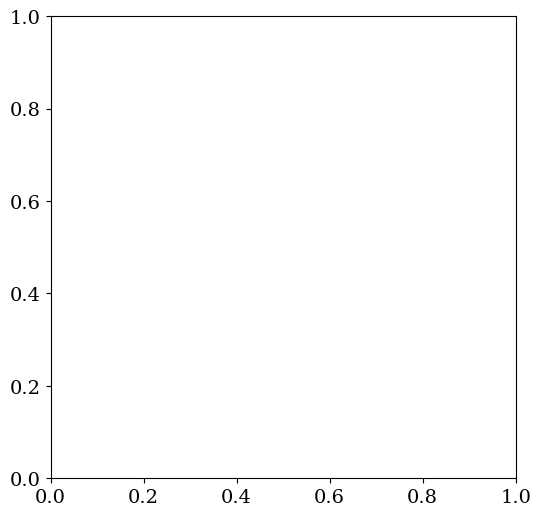

In [42]:
fig, ax = plt.subplots(figsize=(6, 6))
for nu_ in range(-20, 0):
    omega_r = np.linspace(0, 3, int(1e3))
    omega_i = np.linspace(-1, 0, int(1e3))
    X, Y = np.meshgrid(omega_r, omega_i)
    Z = disp_R6(X+1j*Y, nu=nu_)
    index = np.unravel_index(np.nanargmin(np.abs(Z)), Z.shape)
    if np.nanmin(np.abs(Z)) < 1E-2:
        ax.scatter(nu_, np.abs(Y[index].real-res_true.imag), c="blue")

ax.axhline(np.abs(res_hp3.imag-res_true.imag), label="Hammett-Perkins$_{3}$", c="red", linewidth=3)
ax.axhline(np.abs(res_hp4.imag-res_true.imag), label="Hammett-Perkins$_{4}$", c="green", ls="--", linewidth=3)
ax.set_xlabel(r"artificial collisions frequency $\nu$")
ax.set_ylabel(r"damping rate $\gamma$ absolute error w/ $k=1$")

legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.grid()

plt.tight_layout()